In [1]:
# from google.colab import drive
# drive.mount('/content/drive')
%cd ./drive/MyDrive/Colab Notebooks
from model_loader import get_model
import torch
import albumentations as A
from argparse import Namespace
from albumentations.pytorch.transforms import ToTensor
from tqdm import notebook

config = {"train_ratio":.8, "batch_size":16, "n_epochs":50, "verbose":2,
          "gpu_id":0 if torch.cuda.is_available() else 1, "model_fn":"keypointrcnn_resnet50e50-bs8-newalbu-res224-swa_lr5e-5.pth", "n_classes":48,
          "freeze":True, "use_pretrained":True, "model_name":"keypointrcnn_resnet50"}

config = Namespace(**config)


# d = torch.load("./keypointrcnn_resnet50e20-bs16-newalbu-swa-lr.pth", map_location=torch.device('cpu'))
d = torch.load("./keypointrcnn_resnet50e50-bs8-newalbu-res224-swa_lr5e-5.pth")
# device = torch.device('cpu') if config.gpu_id < 0 else torch.device('cuda:%d' % config.gpu_id)
device = torch.device('cuda:%d' % config.gpu_id) if torch.cuda.is_available() else torch.device("cpu")
model = get_model(config).to(device)


# model.load_state_dict(d["model"])

/content/drive/MyDrive/Colab Notebooks


Downloading: "https://download.pytorch.org/models/keypointrcnn_resnet50_fpn_coco-fc266e95.pth" to /root/.cache/torch/hub/checkpoints/keypointrcnn_resnet50_fpn_coco-fc266e95.pth


In [ ]:
# from argparse import Namespace

# config = {"train_ratio":.8, "batch_size":8, "n_epochs":20, "verbose":2,
#           "gpu_id":0 if torch.cuda.is_available() else 1, "model_fn":"densenet121-use_trained-freeze-epoch50-batch32_albumentation_hori_random_vertical_motion_gaussnoise.pth", "n_classes":48,
#           "freeze":True, "use_pretrained":True, "model_name":"densenet"}

# config = Namespace(**config)

In [2]:
import pandas as pd
from torchvision import transforms
from PIL import Image
import os
import numpy as np

df = pd.read_csv("../Keypoint/sample_submission.csv")

In [3]:
import torch

from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, transforms

from sklearn.model_selection import train_test_split

from PIL import Image
import numpy as np

import pandas as pd

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import albumentations as A
from albumentations.pytorch.transforms import ToTensor

class testDataset(object):
  def __init__(self, df, A_transforms):
    self.df = df
    self.transform = A_transforms
    super().__init__()

  def __len__(self):
    return self.df.shape[0]

  def __getitem__(self, idx):
    # load images 
    image_id = self.df.iloc[idx, 0]
    image = Image.open(os.path.join("../Keypoint/test_imgs/", image_id)).convert('RGB')
    image = np.array(image)

    targets ={
    'image': image}

    if self.transform is not None:
      targets = self.transform(**targets)

    image = targets['image']


    return image


transform = A.Compose([
            A.Resize(224, 224, always_apply=True),
            A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            ToTensor()
        ])



def get_loader(config):
  df = pd.read_csv("../Keypoint/sample_submission.csv")

  test_loader = DataLoader(dataset = testDataset(df, transform), batch_size = config.batch_size, shuffle=False)

  return test_loader

test_loader = get_loader(config)

In [ ]:
# 기존
all_predictions = []
model.eval()
with torch.no_grad():
  for input in notebook.tqdm(test_loader):
    predictions = list(model([input[0].to(device).cpu().numpy()])
    for prediction in predictions:
        all_predictions.append(prediction)

all_predictions = np.array(all_predictions)
for i in range(all_predictions.shape[0]):
    all_predictions[i, [2*j for j in range(48//2)]] /= 600 / 1920
    all_predictions[i, [2*j + 1 for j in range(48//2)]] /= 600 / 1080

df.iloc[:, 1:] = all_predictions

In [ ]:
# keypointrcnn
all_predictions = []
model.eval()
with torch.no_grad():
  for input in notebook.tqdm(test_loader):
    inputs = [image.to(device) for image in input]
    pred = model(inputs)
    for i in pred:
      try:
        all_predictions.append(i["keypoints"][0][:, :2].reshape(-1).cpu().numpy())

      except Exception as e :
        print(e)
        all_predictions.append(0)

index 0 is out of bounds for dimension 0 with size 0
index 0 is out of bounds for dimension 0 with size 0
index 0 is out of bounds for dimension 0 with size 0
index 0 is out of bounds for dimension 0 with size 0
index 0 is out of bounds for dimension 0 with size 0
index 0 is out of bounds for dimension 0 with size 0
index 0 is out of bounds for dimension 0 with size 0
index 0 is out of bounds for dimension 0 with size 0
index 0 is out of bounds for dimension 0 with size 0
index 0 is out of bounds for dimension 0 with size 0
index 0 is out of bounds for dimension 0 with size 0
index 0 is out of bounds for dimension 0 with size 0



In [ ]:
for i, v in enumerate(notebook.tqdm(all_predictions)):
  df.iloc[i, 1:] = v

In [ ]:
for i in notebook.tqdm(range(len(df))):
  df.iloc[i, [1 + 2*j for j in range(48//2)]] /= 224 / 1920
  df.iloc[i, [1+ 2*j + 1 for j in range(48//2)]] /=224 / 1080

In [ ]:
df.head(5)

,image,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,left_ear_x,left_ear_y,right_ear_x,right_ear_y,left_shoulder_x,left_shoulder_y,right_shoulder_x,right_shoulder_y,left_elbow_x,left_elbow_y,right_elbow_x,right_elbow_y,left_wrist_x,left_wrist_y,right_wrist_x,right_wrist_y,left_hip_x,left_hip_y,right_hip_x,right_hip_y,left_knee_x,left_knee_y,right_knee_x,right_knee_y,left_ankle_x,left_ankle_y,right_ankle_x,right_ankle_y,neck_x,neck_y,left_palm_x,left_palm_y,right_palm_x,right_palm_y,spine2(back)_x,spine2(back)_y,spine1(waist)_x,spine1(waist)_y,left_instep_x,left_instep_y,right_instep_x,right_instep_y
0,649-2-4-32-Z148_A-0000001.jpg,1260.977652,590.243654,953.831831,650.873803,277.151119,1077.979055,1716.897191,563.296962,1623.313817,497.277542,956.231428,584.854345,1716.897191,607.759074,1570.522940,584.854345,1716.897191,716.893150,1200.988246,673.778458,461.918564,466.288850,142.774822,518.834888,889.043165,650.873803,1568.123474,761.355261,771.464015,650.873803,1380.956595,561.949617,205.163825,1002.528289,1138.599243,548.476271,769.064353,497.277542,1385.755659,627.969074,1716.897191,518.834888,1716.897191,673.778458,1568.123474,1002.528289,1198.588649,784.259916
1,649-2-4-32-Z148_A-0000003.jpg,1260.267072,591.306508,953.294285,650.623815,276.994956,1077.977804,1715.929740,562.995991,1622.398943,496.938094,955.692509,584.565917,1715.929740,607.483925,1569.637887,584.565917,1715.929740,716.681638,1200.311410,673.541786,461.658260,465.931341,145.092594,518.508020,888.542241,650.623815,828.586578,498.286212,771.029205,650.623815,1380.178266,561.647873,205.048207,1002.483117,1137.957589,548.166655,768.630981,496.938094,1384.974714,627.705770,1715.929740,518.508020,1715.929740,673.541786,1567.239859,1002.483117,1197.913252,784.087617
2,649-2-4-32-Z148_A-0000005.jpg,890.623954,538.639449,950.558297,647.855407,276.896569,1077.977510,1712.922756,560.213017,1619.425310,495.492423,952.955671,583.134813,1712.922756,604.708381,1566.683088,583.134813,1712.922756,715.272642,1197.487662,670.777277,461.494250,463.132144,128.259438,515.717579,885.829272,649.203783,955.352979,495.492423,768.357958,649.203783,1379.687936,560.213017,204.975373,1002.470169,1135.155945,541.336163,765.960584,494.144084,1382.085310,626.281913,1712.922756,515.717579,950.558297,538.639449,1566.683088,1002.470169,1197.487662,782.689950
3,649-2-4-32-Z148_A-0000007.jpg,1253.986947,540.238585,1071.588789,652.099244,277.197124,1077.978467,1707.582092,564.497501,1604.383327,541.586335,949.190107,586.060990,1707.582092,607.624516,1316.386283,541.586335,1707.582092,718.137499,1071.588789,625.144901,459.595217,467.461763,123.598709,520.022809,1133.988255,607.624516,949.190107,499.806997,1251.586958,695.226296,1498.784310,563.149824,205.197863,1002.506144,1378.785618,873.125210,1558.783787,608.972229,1503.584290,675.010447,1124.388297,608.972229,1193.987601,630.535755,1558.783787,607.624516,1069.188865,541.586335
4,649-2-4-32-Z148_A-0000009.jpg,1250.315813,579.119445,1068.102984,643.836103,274.518062,1077.977657,1497.262181,778.662701,1609.946463,488.785601,945.828552,577.771180,1703.450448,599.343387,1559.598214,577.771180,1703.450448,711.249439,1190.377415,666.756649,701.279755,456.427272,1312.651716,689.677195,519.066860,912.140996,823.554121,666.756649,885.890089,643.836103,1372.590245,553.502406,204.989466,1001.126502,1128.041382,556.198899,1554.803074,600.691652,1374.987749,622.263933,1703.450448,510.357881,1068.102984,533.278390,1557.200710,645.184405,1190.377415,780.010929


In [ ]:
index = df[df["nose_x"] == 0].index
print(index)

Int64Index([448, 449, 453, 458, 461, 462], dtype='int64')


In [ ]:
df.iloc[448:464, :]

,image,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,left_ear_x,left_ear_y,right_ear_x,right_ear_y,left_shoulder_x,left_shoulder_y,right_shoulder_x,right_shoulder_y,left_elbow_x,left_elbow_y,right_elbow_x,right_elbow_y,left_wrist_x,left_wrist_y,right_wrist_x,right_wrist_y,left_hip_x,left_hip_y,right_hip_x,right_hip_y,left_knee_x,left_knee_y,right_knee_x,right_knee_y,left_ankle_x,left_ankle_y,right_ankle_x,right_ankle_y,neck_x,neck_y,left_palm_x,left_palm_y,right_palm_x,right_palm_y,spine2(back)_x,spine2(back)_y,spine1(waist)_x,spine1(waist)_y,left_instep_x,left_instep_y,right_instep_x,right_instep_y
448,698-3-5-34-Z94_D-0000001.jpg,1061.310948,504.965078,1092.129233,773.511609,1113.465009,455.034387,1016.268899,850.431919,1004.415697,490.120807,1101.611677,730.328276,1113.465009,826.141368,1101.611677,730.328276,1113.465009,758.667265,1021.010154,815.345462,1096.870488,850.431919,980.709359,518.459906,994.933188,688.494350,978.338732,503.615635,985.450614,517.110427,1087.387913,455.034387,1113.465009,475.276537,1061.310948,645.311018,1030.492663,488.771365,973.597478,850.431919,1061.310948,490.120807,1113.465009,730.328276,980.709359,490.120807,1011.527645,531.954697
449,698-3-5-34-Z94_D-0000003.jpg,1061.310948,504.965078,1092.129233,773.511609,1113.465009,455.034387,1016.268899,850.431919,1004.415697,490.120807,1101.611677,730.328276,1113.465009,826.141368,1101.611677,730.328276,1113.465009,758.667265,1021.010154,815.345462,1096.870488,850.431919,980.709359,518.459906,994.933188,688.494350,978.338732,503.615635,985.450614,517.110427,1087.387913,455.034387,1113.465009,475.276537,1061.310948,645.311018,1030.492663,488.771365,973.597478,850.431919,1061.310948,490.120807,1113.465009,730.328276,980.709359,490.120807,1011.527645,531.954697
450,698-3-5-34-Z94_D-0000005.jpg,1061.310948,504.965078,1092.129233,773.511609,1113.465009,455.034387,1016.268899,850.431919,1004.415697,490.120807,1101.611677,730.328276,1113.465009,826.141368,1101.611677,730.328276,1113.465009,758.667265,1021.010154,815.345462,1096.870488,850.431919,980.709359,518.459906,994.933188,688.494350,978.338732,503.615635,985.450614,517.110427,1087.387913,455.034387,1113.465009,475.276537,1061.310948,645.311018,1030.492663,488.771365,973.597478,850.431919,1061.310948,490.120807,1113.465009,730.328276,980.709359,490.120807,1011.527645,531.954697
451,698-3-5-34-Z94_D-0000007.jpg,1047.523368,504.938519,966.531437,834.282385,1118.986947,454.997014,1007.027435,854.528912,1099.929984,475.243541,1104.694257,676.359337,1118.986947,831.582838,1107.076329,733.049673,1118.986947,761.394841,1023.702262,819.434951,1018.937988,475.243541,1118.986947,633.166662,985.588401,633.166662,1118.986947,819.434951,1111.840602,454.997014,1088.019366,454.997014,1118.986947,475.243541,1059.434052,646.664322,1014.173780,490.091049,959.385158,854.528912,1071.344604,490.091049,1118.986947,733.049673,1071.344604,576.476326,1002.263227,533.283651
452,698-3-5-34-Z94_D-0000009.jpg,1080.422189,548.522656,1085.149514,768.478669,1120.604030,518.835366,1120.604030,518.835366,1101.694990,536.377859,1108.785880,756.333872,1052.058563,634.885753,1108.785880,562.016896,1120.604030,780.623466,1007.149397,830.552207,1101.694990,860.239571,1002.422006,548.522656,1002.422006,518.835366,974.058380,586.306527,1113.513140,818.407337,1068.604039,518.835366,1120.604030,560.667453,1068.604039,695.609812,1018.967481,548.522656,1068.604039,860.239571,1120.604030,622.740955,1120.604030,756.333872,974.058380,647.030623,981.149270,586.306527
453,698-3-5-34-Z94_D-0000011.jpg,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
454,698-3-5-3

In [ ]:
df.iloc[462, 1:] = df.iloc[457, 1:]

In [ ]:
df.to_csv("result.csv", index = False)

In [ ]:
all_predictions

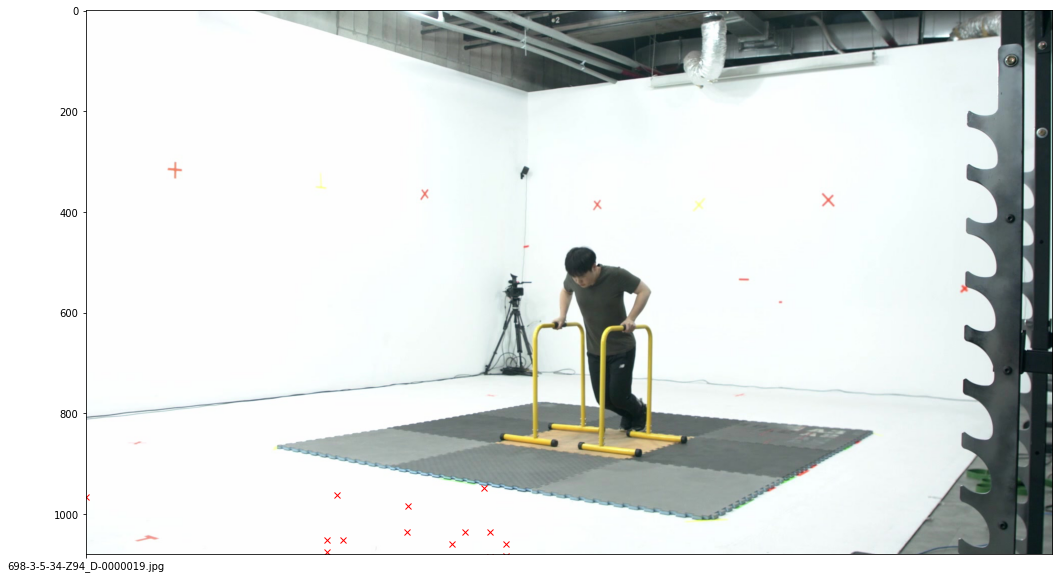

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))     
img = Image.open(os.path.join("../Keypoint/test_imgs/", df.iloc[457, 0]))
img_np = np.array(img)


for j in range(0, 48, 2):
  plt.plot(df.iloc[457, j], df.iloc[457, j + 1],'rx')
  plt.imshow(img_np)

In [ ]:
import torch

from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, transforms

from sklearn.model_selection import train_test_split

from PIL import Image
import numpy as np

import pandas as pd

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import albumentations as A
from albumentations.pytorch.transforms import ToTensor

class testDataset(object):
  def __init__(self, df, A_transforms):
    self.df = df
    self.transform = A_transforms
    super().__init__()

  def __len__(self):
    return self.df.shape[0]

  def __getitem__(self, idx):
    # load images 
    image_id = self.df.iloc[idx, 0]
    image = Image.open(os.path.join("../Keypoint/test_imgs/", image_id)).convert('RGB')
    image = np.array(image)

    targets ={
    'image': image}

    if self.transform is not None:
      targets = self.transform(**targets)

    image = targets['image']


    return image


transform = A.Compose([
            A.Resize(224, 224, always_apply=True),
            A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            ToTensor()
        ])

def collate_fn(batch: torch.Tensor):
    return tuple(zip(*batch))

def get_loader(config):
  df = pd.read_csv("../Keypoint/sample_submission.csv")

  test_loader = DataLoader(dataset = testDataset(df, transform), batch_size = config.batch_size, shuffle=True,
                             num_workers=8, collate_fn=collate_fn)

  return test_loader


In [ ]:
test_loader = get_loader(config)

In [ ]:
image = next(iter(test_loader))

In [ ]:
model.eval()
pred = model(image.to(device))

[{'boxes': tensor([], device='cuda:0', size=(0, 4), grad_fn=<StackBackward>),
  'keypoints': tensor([], device='cuda:0', size=(0, 24, 3)),
  'keypoints_scores': tensor([], device='cuda:0', size=(0, 24)),
  'labels': tensor([], device='cuda:0', dtype=torch.int64),
  'scores': tensor([], device='cuda:0', grad_fn=<IndexBackward>)},
 {'boxes': tensor([], device='cuda:0', size=(0, 4), grad_fn=<StackBackward>),
  'keypoints': tensor([], device='cuda:0', size=(0, 24, 3)),
  'keypoints_scores': tensor([], device='cuda:0', size=(0, 24)),
  'labels': tensor([], device='cuda:0', dtype=torch.int64),
  'scores': tensor([], device='cuda:0', grad_fn=<IndexBackward>)},
 {'boxes': tensor([], device='cuda:0', size=(0, 4), grad_fn=<StackBackward>),
  'keypoints': tensor([], device='cuda:0', size=(0, 24, 3)),
  'keypoints_scores': tensor([], device='cuda:0', size=(0, 24)),
  'labels': tensor([], device='cuda:0', dtype=torch.int64),
  'scores': tensor([], device='cuda:0', grad_fn=<IndexBackward>)},
 {'boxe

In [ ]:
model.eval()
pred = model(image[0].to(device))

ValueError: ignored

In [ ]:
x = [torch.float32(torch.rand(3, 224, 224)).to(device), torch.float32(torch.rand(3, 224, 224)).to(device)]

TypeError: ignored

In [ ]:
x[0].size()

torch.Size([3, 300, 400])

In [ ]:
model.eval()
pred = model(x)

In [ ]:
pred

[{'boxes': tensor([], device='cuda:0', size=(0, 4), grad_fn=<StackBackward>),
  'keypoints': tensor([], device='cuda:0', size=(0, 24, 3)),
  'keypoints_scores': tensor([], device='cuda:0', size=(0, 24)),
  'labels': tensor([], device='cuda:0', dtype=torch.int64),
  'scores': tensor([], device='cuda:0', grad_fn=<IndexBackward>)},
 {'boxes': tensor([], device='cuda:0', size=(0, 4), grad_fn=<StackBackward>),
  'keypoints': tensor([], device='cuda:0', size=(0, 24, 3)),
  'keypoints_scores': tensor([], device='cuda:0', size=(0, 24)),
  'labels': tensor([], device='cuda:0', dtype=torch.int64),
  'scores': tensor([], device='cuda:0', grad_fn=<IndexBackward>)}]

In [ ]:
model(x)

[{'boxes': tensor([], device='cuda:0', size=(0, 4), grad_fn=<StackBackward>),
  'keypoints': tensor([], device='cuda:0', size=(0, 24, 3)),
  'keypoints_scores': tensor([], device='cuda:0', size=(0, 24)),
  'labels': tensor([], device='cuda:0', dtype=torch.int64),
  'scores': tensor([], device='cuda:0', grad_fn=<IndexBackward>)},
 {'boxes': tensor([], device='cuda:0', size=(0, 4), grad_fn=<StackBackward>),
  'keypoints': tensor([], device='cuda:0', size=(0, 24, 3)),
  'keypoints_scores': tensor([], device='cuda:0', size=(0, 24)),
  'labels': tensor([], device='cuda:0', dtype=torch.int64),
  'scores': tensor([], device='cuda:0', grad_fn=<IndexBackward>)}]

In [ ]:
pred[0]["keypoints"]

tensor([], device='cuda:0', size=(0, 24, 3))

In [ ]:
model = get_model(config)